In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pytz
import sklearn
import scipy

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import umap
import hdbscan

In [2]:
import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
   
# Suppress SettingWithCopyWarning


In [3]:
data = pd.read_csv('CPS.csv')

In [4]:
# Select and rename relevant columns for analysis out of the 356 original columns 
selected_columns = {
    # Household Information
    'HUFINAL': 'interview_outcome',
    'hrnumhou': 'household_members',  # Number of members in a household
    'hefaminc' : 'family_income',

    # Education and Certification Details
    'peschlvl': 'highest_level_of_school',  # Highest level of school 
    'peeduca': 'education_level',  # Highest level of education completed
    'peedegr': 'highest_degree_earned',  # Highest degree earned
    'petrain': 'received_job_training',  # Received job training past high school
    'pecert1': 'professional_certification1',  # Professional certification 1
    'pecert2': 'cert_issued_by_state_or_gov',  # Is certificate issued by the state or the federal government?
    'pecert3': 'is_cert_required',  # Is certification needed for the job?

    # Employment and Income Details
    'pemlr': 'employment_status',  # Employment status
    'prunedor': 'duration_of_unemployment',  # Duration of unemployment
    'hefaminc': 'family_income',  # Family income
    'primind1': 'primary_industry_code_job1',  # Primary industry code for job 1
    'peio1icd': 'industry_code_job1',  # Industry code for job 1
    'ptio1ocd': 'occupation_code_job1',  # Occupation code for job 1
    'primind2': 'primary_industry_code_job2',  # Primary industry code for job 2
    'peio2icd': 'industry_code_job2',  # Industry code for second job 
    'ptio2ocd': 'occupation_code_job2',  # Occupation code for job 2
    'puwk': 'did_work_last_week',  # Did the individual work last week
    
    # Earnings
    'pternh1c': 'earnings_first_job',  # Earnings from the first job
    'pthr': 'total_hours_worked',  # Total hours worked
    'pternwa': 'weekly_earnings',  # Weekly earnings

    # Demographic Variables
    'ptdtrace': 'race',  # Race
    'prtage': 'age', 
    'pesex': 'gender',  # Gender
    'prcitshp': 'citizenship_status',  # Citizenship status

     # Geographic Information
    'gestfips': 'state_code',  # State FIPS code
    

     # Work Arrangement and Preferences
    'pehruslt': 'usual_hours_worked',  # Usual hours worked per week
    'pewa': 'work_at_home',  # Ability or frequency of working from home
    'pewm': 'work_multiple_jobs',  # Working multiple jobs
    
   
     # Job Search and Unemployment Details
    'pruntype': 'reason_for_unemployment',  # Reason for unemployment
    'pulaydtx': 'weeks_looking_for_work',  # Weeks spent looking for work
    'pulkm1': 'primary_method_of_job_search',  # Primary method of job search
    'puhrck12': 'job_search_method',  # Job search method

     # Health and Disability
    'pedisabl': 'disability_status',  # Disability status
    'pehspnon': 'health_status_impacting_work',  # Health status impacting work
    
}

In [5]:
# Filter the dataset to keep only the selected columns, verifying they exist
data = data[[col for col in selected_columns if col in data.columns]].rename(columns=selected_columns)


In [6]:
# Replace NaN values with -1
data.fillna(-1, inplace=True)

In [7]:
# Impute -1 in Family income with weekly earning values when family income is -1
data.loc[(data['weekly_earnings'] != -1) & (data['family_income'] == -1), 'family_income'] = data['weekly_earnings']

In [8]:
data.shape

(126784, 26)

In [9]:
data = data.copy()
data = data.loc[(data['family_income'] != -1)]

In [10]:
data.shape

(99250, 26)

In [11]:
# Calculate the percentage of -1 for each column and drop columns with more than 60% -1 values
columns_to_drop = [column for column in data.columns if (data[column] == -1).sum() / len(data) > 0.60]

# Drop these columns
data.drop(columns=columns_to_drop, inplace=True)

In [12]:
data_reduced = data.copy()

In [13]:
# Change float to category
categorical_columns = ['family_income', 'interview_outcome', 'education_level', 'professional_certification1', 'employment_status', 'race', 'gender', 'citizenship_status', 'state_code', 'health_status_impacting_work']
for col in categorical_columns:
    data[col] = data[col].astype('category')
    
int32_columns = ['household_members', 'total_hours_worked', 'age', 'state_code']
for col in int32_columns:
    data[col] = data[col].astype('int32')

In [14]:
# Define the preprocessing for numeric and categorical data
# Preprocessor for transforming data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), int32_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'),categorical_columns)
    ])

#  Preprocess the data
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
data_transformed = pipeline.fit_transform(data_reduced)

In [15]:
data_transformed.shape

(99250, 140)

In [16]:
# Reduce dimensions with UMAP
reducer = umap.UMAP(n_neighbors=50, n_components=3, min_dist=0.0)
embedding = reducer.fit_transform(data_transformed)


In [17]:
education_l = data_reduced['education_level'].unique().astype(int)


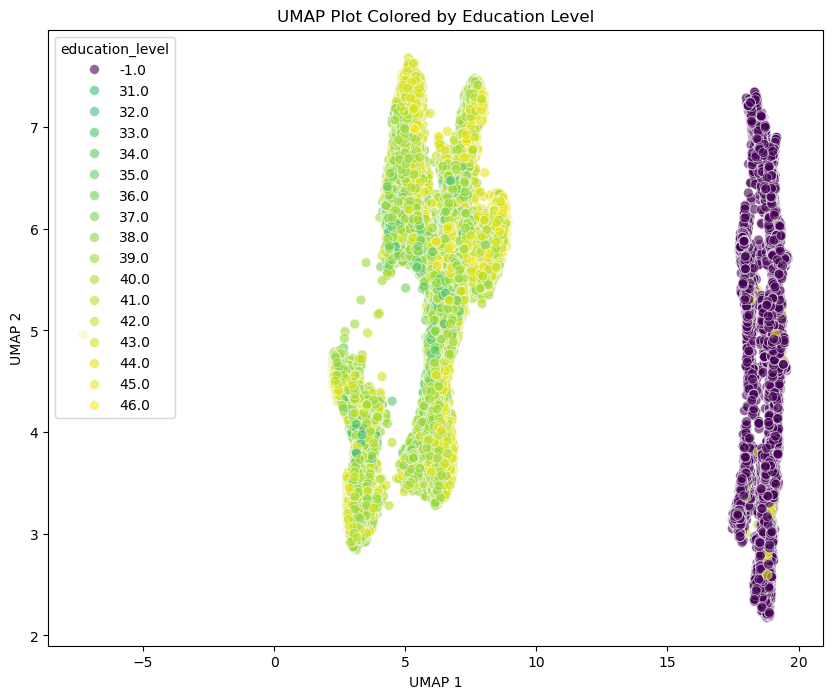

In [18]:

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=data_reduced['education_level'], palette='viridis', s=50, alpha=0.6, legend='full')

plt.title('UMAP Plot Colored by Education Level')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

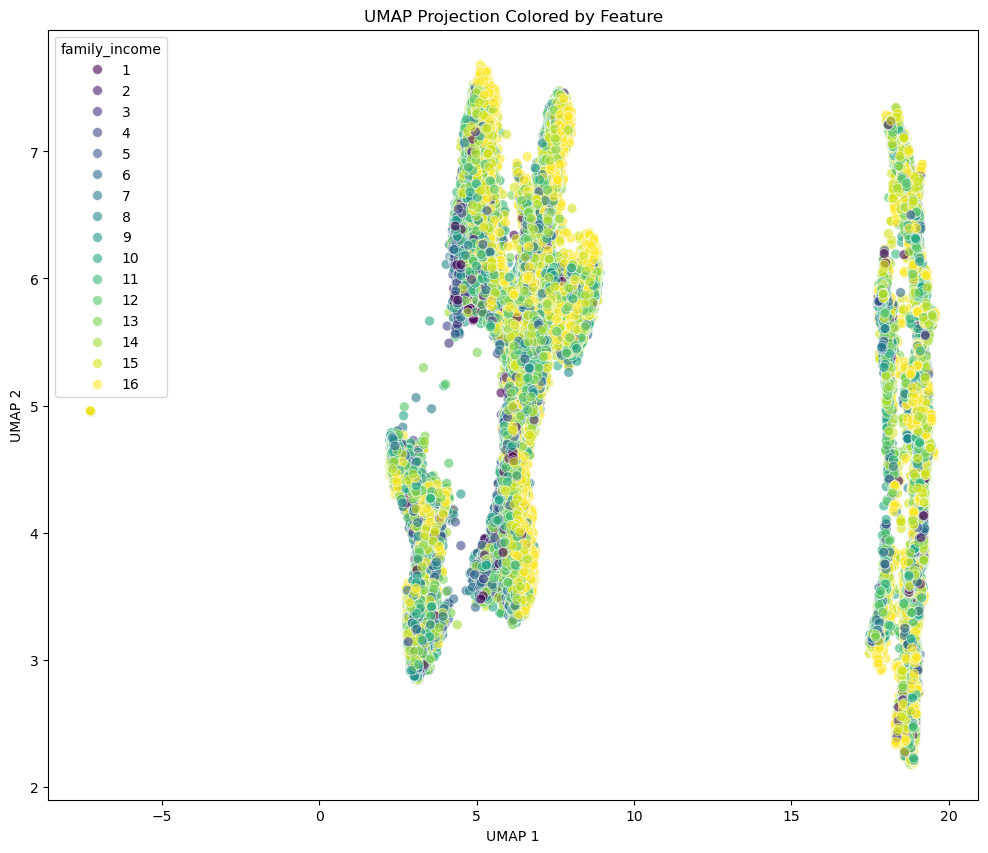

In [19]:
# Visualize a feature of interest in the original data
feature_of_interest = 'family_income'
plt.figure(figsize=(12, 10))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=data_reduced[feature_of_interest], palette='viridis', s=50, alpha=0.6, legend='full')
plt.title('UMAP Projection Colored by Feature')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

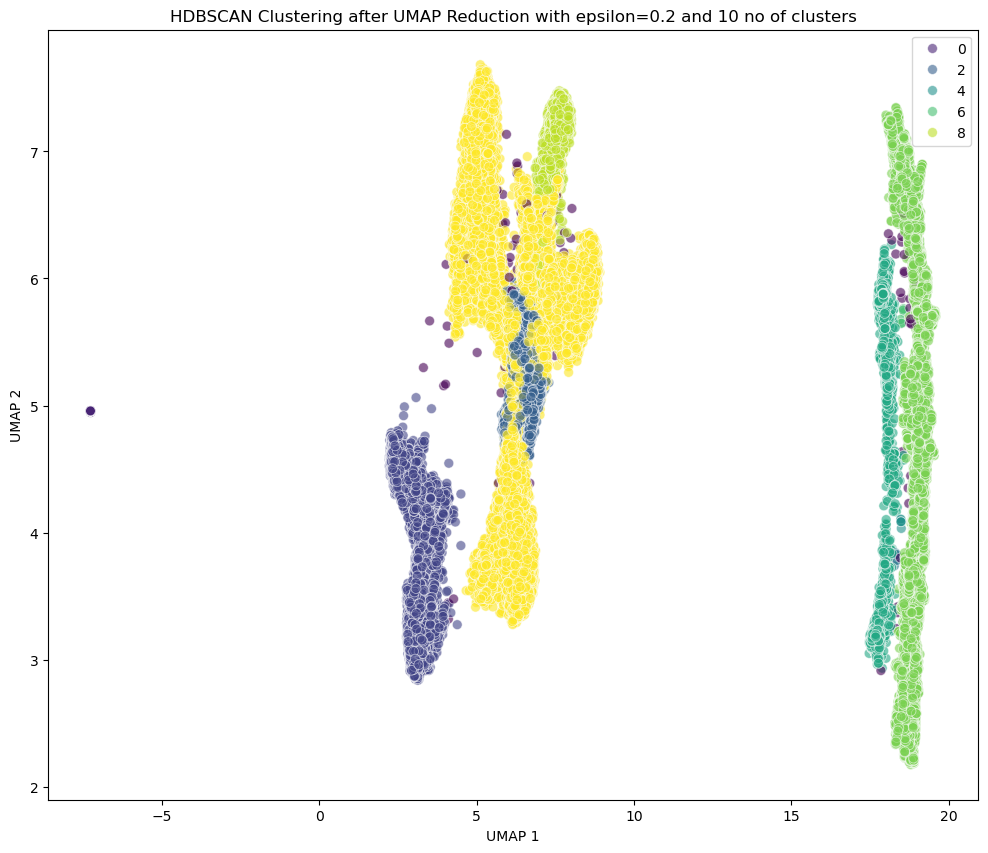

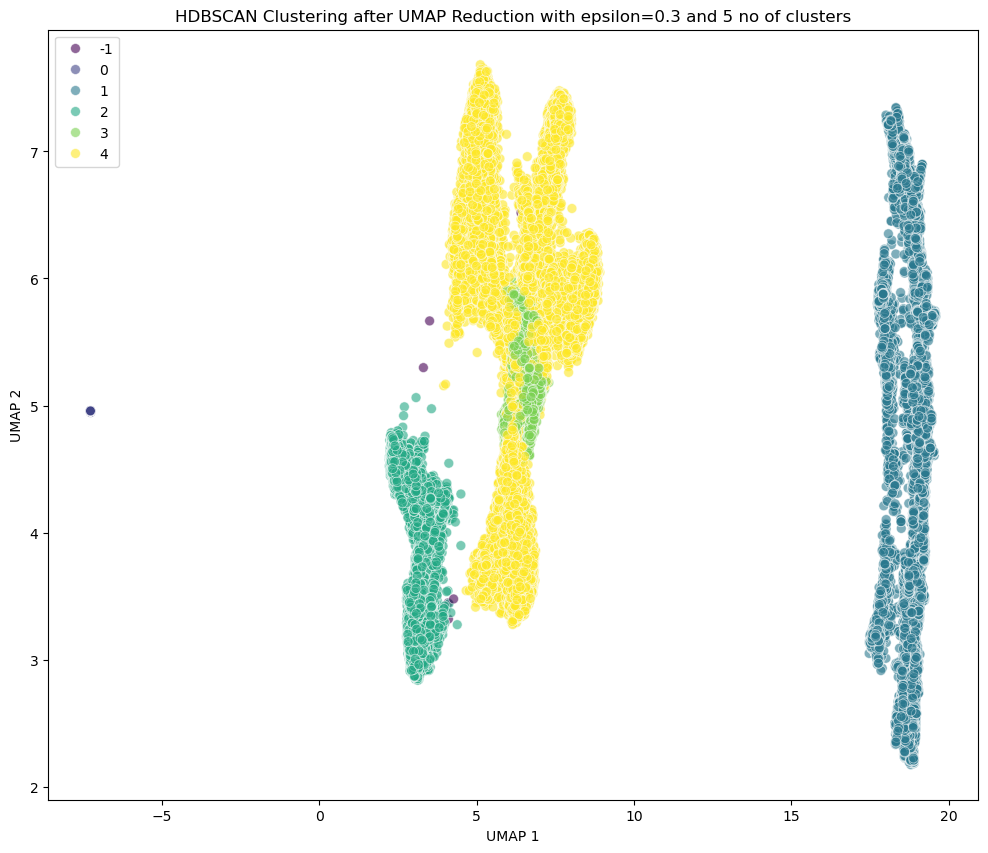

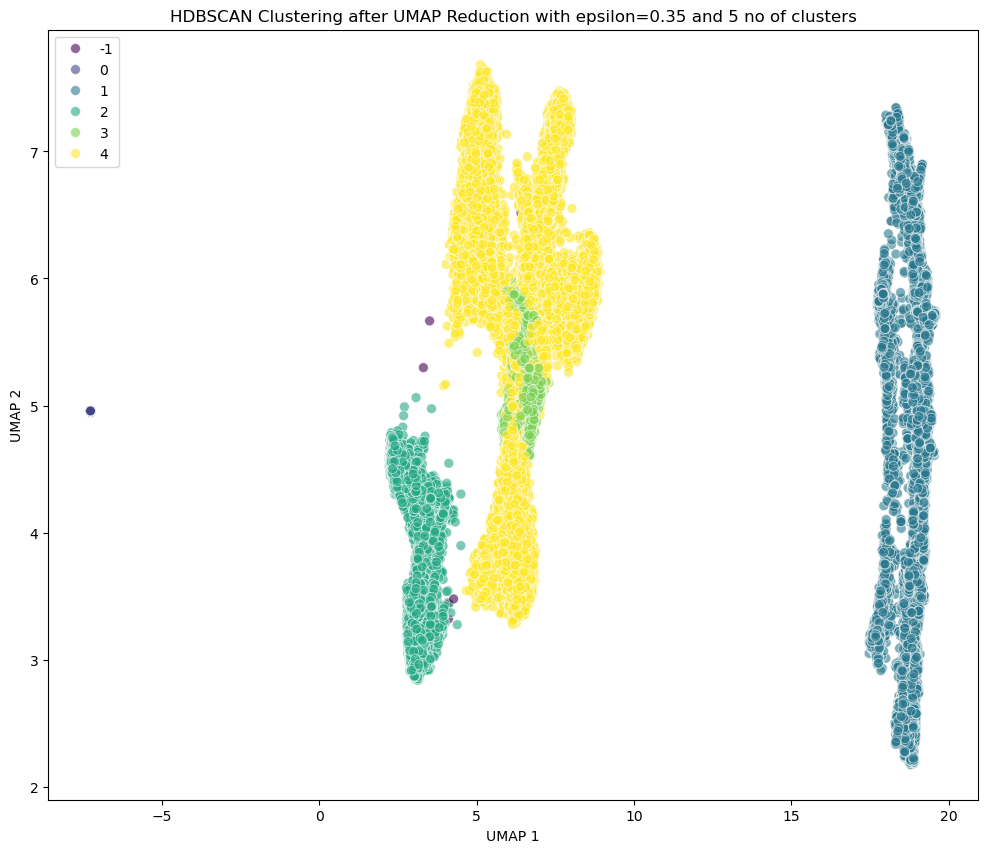

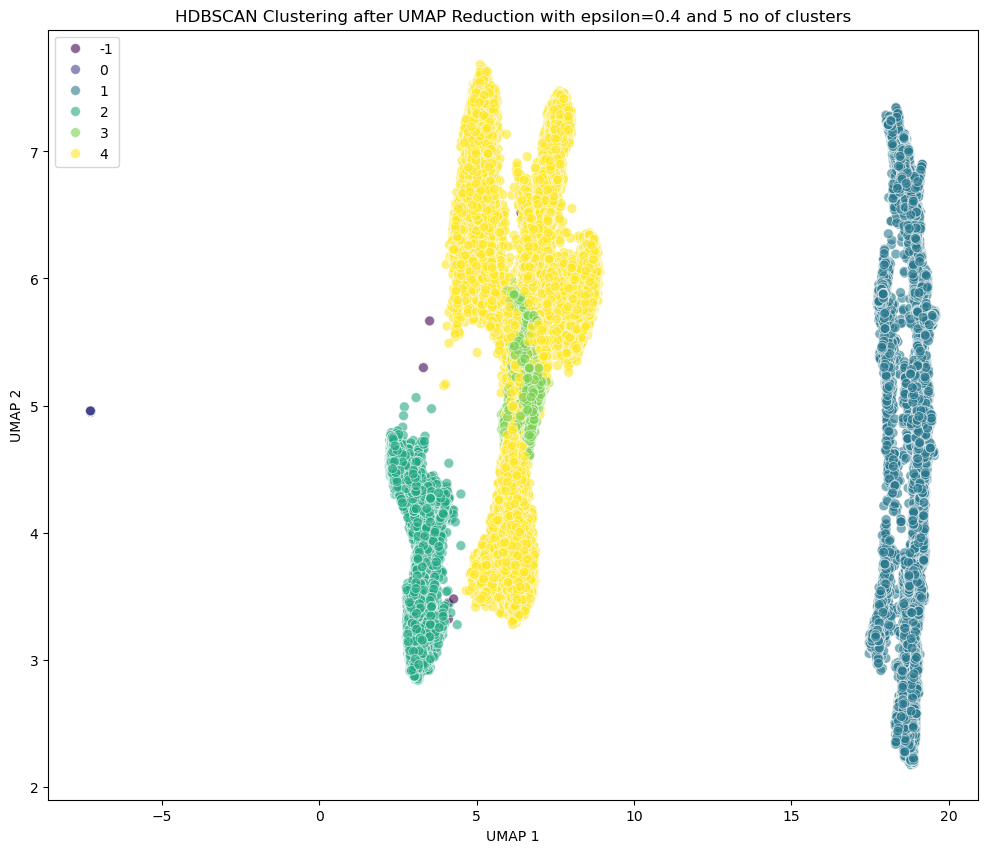

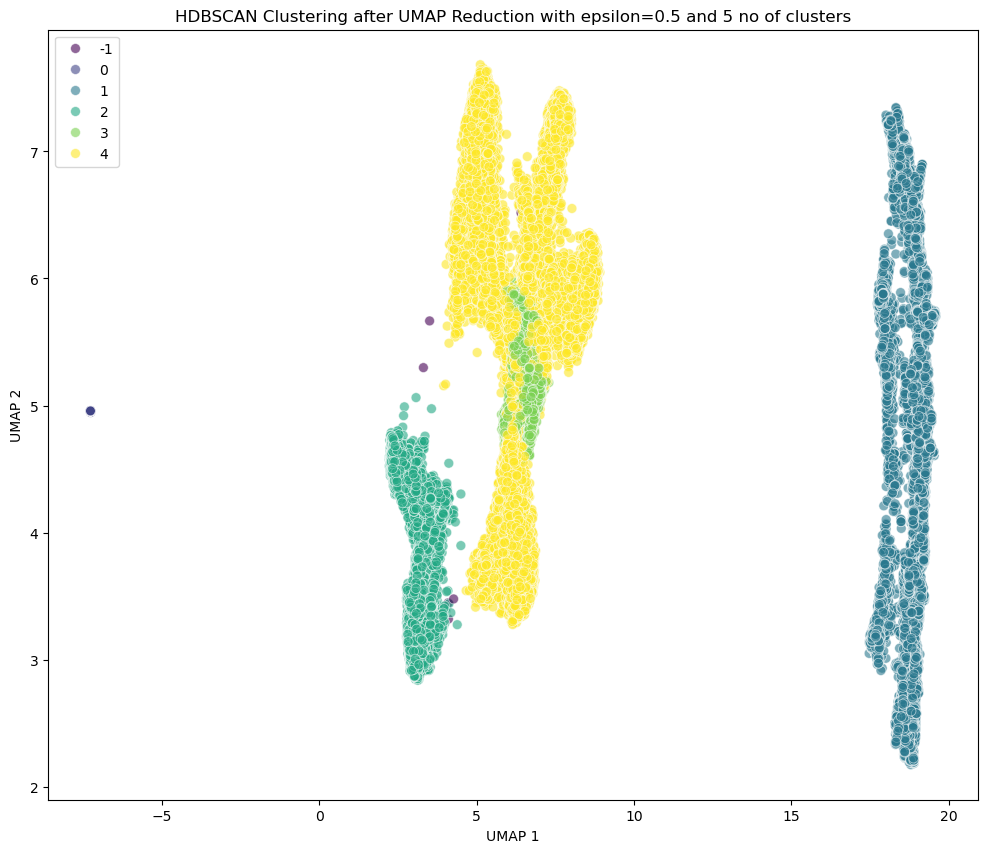

In [20]:
for epsilon in [0.2, 0.3, 0.35, 0.4, 0.5]:  # Exploring different epsilon values
    clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=5, cluster_selection_epsilon=epsilon)
    cluster_labels = clusterer.fit_predict(embedding)

    plt.figure(figsize=(12, 10))
    
    # Create a scatter plot for coloring based on labels.
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=cluster_labels, palette='viridis', s=50, alpha=0.6)

    # Calculate the number of clusters (excluding noise)
    num_clusters = len(np.unique(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    
    # Add titles and labels
    plt.title(f'HDBSCAN Clustering after UMAP Reduction with epsilon={epsilon} and {num_clusters} no of clusters')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    
    # Show the plot
    plt.show()

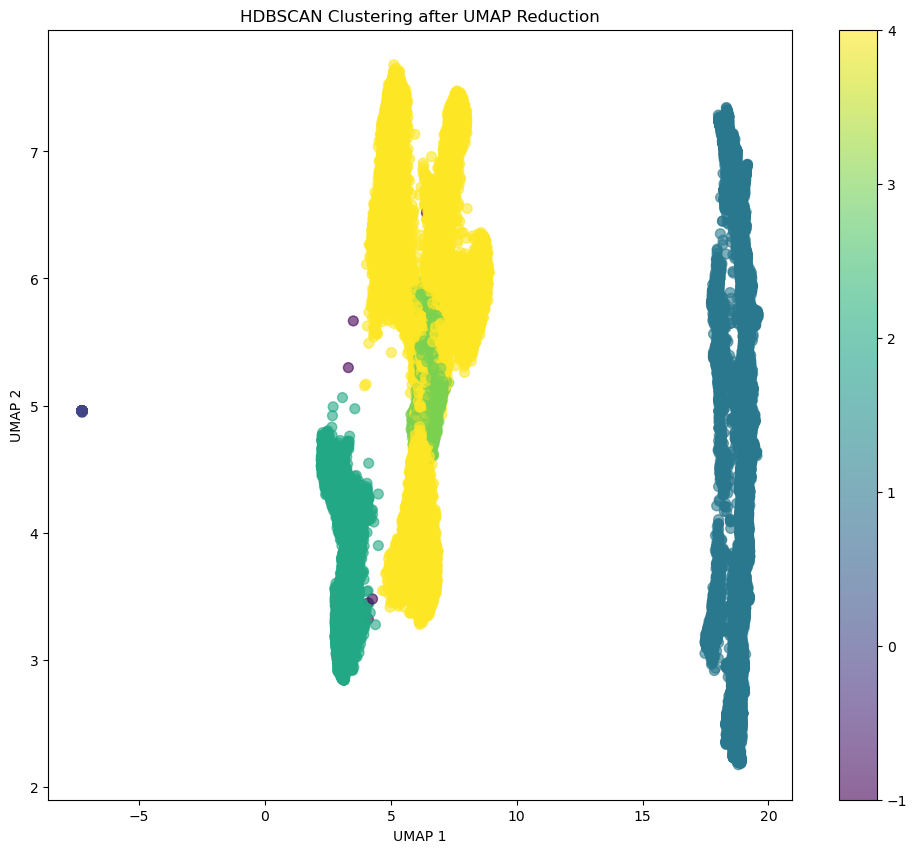

In [21]:

clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=5, cluster_selection_epsilon=0.4)
cluster_labels = clusterer.fit_predict(embedding)

plt.figure(figsize=(12, 10))

# Create a scatter plot. 'c' is used for coloring based on labels.
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.6)

# Add a colorbar to the plot
plt.colorbar(scatter)

# Add titles and labels
plt.title('HDBSCAN Clustering after UMAP Reduction')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Show the plot
plt.show()

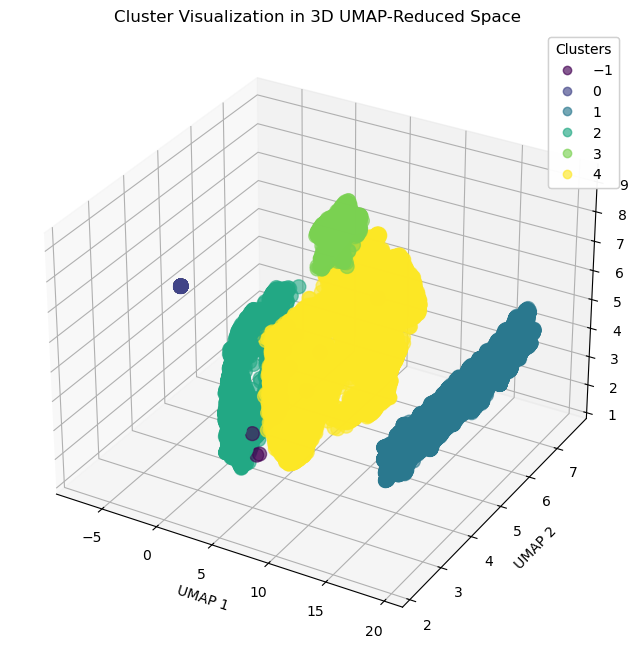

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=cluster_labels, cmap='viridis', s=100, alpha=0.6)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('WMAP 3')
plt.title('Cluster Visualization in 3D UMAP-Reduced Space')
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.show()

In [ ]:
# Create a DataFrame with the first few principal components and cluster labels
UMAP_df = pd.DataFrame(data=embedding[:, :4], columns=[f'PC{i+1}' for i in range(4)])
UMAP_df['Cluster'] = clusters

sns.pairplot(pca_df, hue='Cluster', palette='viridis', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of the First Four Principal Components', verticalalignment='top')
plt.show()

# Evaluation

In [28]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(embedding, cluster_labels)

print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.2762371



A silhouette score of 0.2762371 indicates somewhat reasonable clustering, but there's room for improvement.

In [22]:
data_reduced['Cluster_Labels'] = cluster_labels

# Exploring 

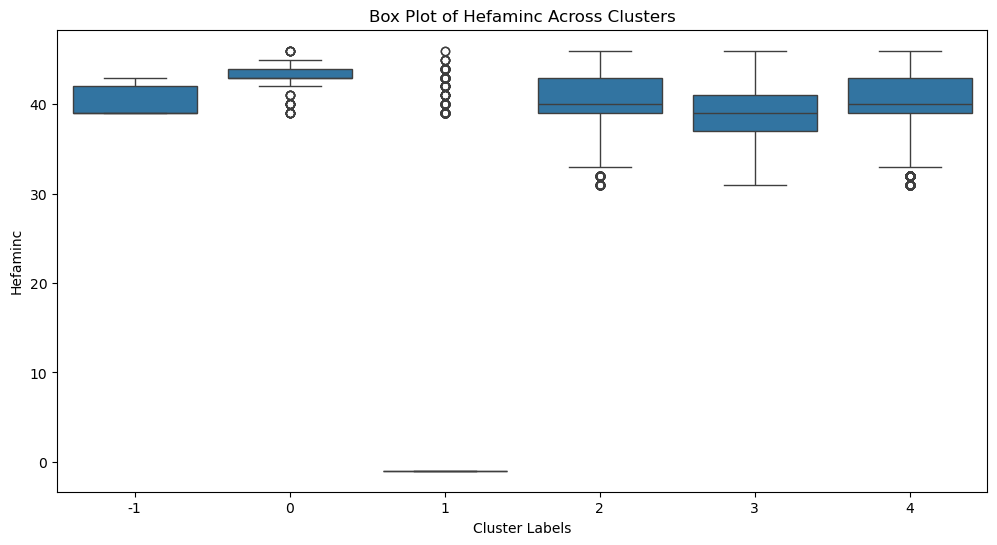

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster_Labels', y='education_level', data=data_reduced)
plt.title('Box Plot of Hefaminc Across Clusters')
plt.xlabel('Cluster Labels')
plt.ylabel('Hefaminc')
plt.show()